# Card Classifier

Tackle this problem into 3 parts:

1) Pytorch Dataset
2) Pytorch Model
3) Pytorch Training Loop

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import timm

import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.11 (main, May  7 2023, 17:32:05) [Clang 16.0.3 ]
PyTorch version 2.6.0
Torchvision version 0.21.0
Numpy version 2.2.2
Pandas version 2.2.3


## 📌 Step 1. Pytorch Dataset (and Dataloader)
Training a pytorch model without first having the dataset setup correctly is impossible.

### This is why datasets are important:

* It's an organized way to structure how the data and labels are loaded into the model.
* We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!


#### ImageFolder
A generic data loader where the images are arranged in this way by default:
* root/dog/xxx.png
* root/dog/xxy.png
* root/dog/[...]/xxz.png
* root/cat/123.png
* root/cat/nsdf3.png
* root/cat/[...]/asd932_.png

**Parameters:**
**root** (str or pathlib.Path) – Root directory path.

**transform** (callable, optional) – A function/transform that takes in a `PIL image` and returns a transformed version. *E.g, transforms.RandomCrop*


In [87]:
from pathlib import Path


class PlayingCardDataset(Dataset):
    def __init__(self, data_dir: Path | str, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @property
    def classes(self):
        return self.data.classes

### Create dataset

In [88]:
card_path = "dataset/cards/train"
dataset = PlayingCardDataset(card_path)

In [89]:
len(dataset)

7624

0


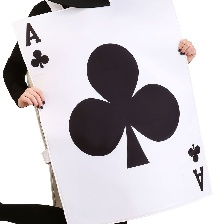

In [90]:
image, label = dataset[0]
print(label)
image

In [91]:
# get a dictionary associating target values with folder name.
target_to_class = {v:k for k,v in ImageFolder(card_path).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

#### Image Transformer

A transformer in PyTorch, specifically in the `torchvision.transforms` module, refers to a set of operations applied to images, mainly used to preprocess input data for neural networks.

In [92]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

dataset = PlayingCardDataset(data_dir=card_path, transform=transform)

In [93]:
image, label = dataset[0]
image.shape

torch.Size([3, 128, 128])

### Dataloader

* Batching our dataset
* It's faster to train the model in batches instead of one big data at a time.

In PyTorch, a DataLoader is a key component used to efficiently load and batch data for training machine learning models. It provides features such as shuffling, parallel data loading, and mini-batch processing, making it easier to handle large datasets.

#### 🔹 How DataLoader works
The `torch.utils.data.DataLoader` wraps around a dataset and allows easy iteration through batches. It works together with Dataset, which defines how data is loaded and processed.

**Key Parameters of DataLoader:**
* `dataset` – The dataset from which to load data (must be a `torch.utils.data.Dataset`).
* `batch_size` – Number of samples per batch (default: `1`).
* `shuffle` – Whether to shuffle data before each epoch (`True` for randomization).
* `num_workers` – Number of subprocesses used for data loading (higher values speed up loading for large datasets).
* `drop_last` – Whether to drop the last batch if it’s smaller than `batch_size`.

In [94]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [95]:
for images, labels in dataloader:
    break

In [96]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

## 📌 Step 2. Pytorch Model

### 🔹 Understanding PyTorch Models
In PyTorch, a model is a neural network that consists of layers, activation functions, and parameters that learn patterns from data. Models in PyTorch are built using the `torch.nn.Module` class, which provides a flexible way to define, modify, and train deep learning architectures.

### 🔹 General Explanation
A typical PyTorch model consists of:

* `Layers` – The building blocks of a network (e.g., convolutional layers, fully connected layers).
* `Forward Pass` – Defines how data flows through the model.
* `Loss Function` – Measures how well the model's predictions match the ground truth.
* `Optimizer` – Updates the model’s parameters based on the loss function.

### 📌 Key Concept: Understanding Model Shape
Understanding a PyTorch model is about knowing the shape of data at each layer. The final layer is the most important one to modify because it determines the number of output classes for the task.

### 🔹 Summary
✅ PyTorch models are built using torch.nn.Module.

✅ Custom models require defining layers and a forward pass.

✅ Pretrained models (from torchvision or timm) can be modified to fit specific tasks.

✅ Understanding a model means knowing the data shape at each layer and adjusting the final layer for the task at hand. 🚀


In [97]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):  # 52 standard deck + 1 joker card
        super(SimpleCardClassifier, self).__init__()

        self.base_model = timm.create_model(
            model_name="efficientnet_b0", pretrained=True
        )

        # The reason we remove the last layer ([:-1]) is:
        # ✅ Pretrained models have a default classification head (e.g., EfficientNet-B0 has a final layer for 1000 ImageNet classes).
        # ✅ Since we want 53 custom classes, we remove the last layer and later add our own classification head.
        # If we didn’t remove the last layer, the model would output predictions for 1000 classes instead of the 53 we need. 🚀
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        # The output size of EfficientNet-B0 before the classification layer is 1280
        enet_out_size = 1280

        # Define a new classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps into a 1D tensor
            nn.Linear(
                enet_out_size, num_classes
            ),  # Fully connected layer for 53 classes
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [98]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [99]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

## 📌 Step 3: The Training Loop
Now that we understand the general paradigm of PyTorch datasets and models, we need to define the process for training our model.

### 🔹 Key Considerations
* We want to validate our model on data it has not been trained on.
* This is typically done by splitting our dataset into training and validation sets.
* In PyTorch, we can create two datasets using the same dataset class.
### 🔹 Important Terms
* Epoch – One complete pass through the entire training dataset.
* Step – A single batch of data, as defined in our DataLoader.
### 🔹 Understanding the Training Loop
This loop is fundamental in training deep learning models:

1) Load data in batches using the DataLoader.
2) Pass each batch through the model.
3) Calculate the loss (how well the model is performing).
4) Perform backpropagation to update model weights.

While there are libraries that automate this, it’s essential to write it manually at least once to understand how it works.

### 🔹 Key Components to Choose
✅ Optimizer – Responsible for updating model weights.
* Adam is a great starting point for most tasks.

✅ Loss Function – Defines what the model will optimize.
* The choice depends on the task (e.g., CrossEntropyLoss for classification).

In [100]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Setup Datasets

In [101]:
train_folder = 'dataset/cards/train/'
valid_folder = 'dataset/cards/valid/'
test_folder = 'dataset/cards/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Simple model training loop

In [102]:
num_epochs = 25
train_losses, val_losses = [],[]

# Device setup
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
        

# Model setup
model = SimpleCardClassifier(num_classes=53)
model.to(device=device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training loop", ascii=True, ncols=100):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        # Gradient check how each weight impact
        optimizer.zero_grad() # Clear gradients from the previous step
        outputs = model(images) # Forward pass: Get model predictions
        loss = criterion(outputs, labels) # Compute loss
        
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model weights based on gradients

        running_loss += loss.item() * labels.size(0) # Accumulate batch loss
    
    train_loss = running_loss / len(train_loader.dataset) # Compute average loss for the epoch
    train_losses.append(train_loss) # Store loss for visualization later
    

    model.eval() # Set model to evaluation mode (disables dropout, batch norm updates, etc.)
    running_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations to save memory and speed up computation
        for images, labels in tqdm(val_loader, desc='Validation loop', ascii=True, ncols=100):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Validation loop: 100%|################################################| 9/9 [00:00<00:00, 17.13it/s]


Epoch 1/25 - Train loss: 1.5735493828342193, Validation loss: 0.4300868086095126


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 15.98it/s]


Epoch 2/25 - Train loss: 0.5433188082663986, Validation loss: 0.25742111116085414


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 16.14it/s]


Epoch 3/25 - Train loss: 0.326622940498284, Validation loss: 0.27417959424684635


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 13.56it/s]


Epoch 4/25 - Train loss: 0.2597294912164384, Validation loss: 0.2132386454996073


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 13.08it/s]


Epoch 5/25 - Train loss: 0.18293005007574215, Validation loss: 0.23245149873337656


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.98it/s]


Epoch 6/25 - Train loss: 0.1866621559589382, Validation loss: 0.162338950161664


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.94it/s]


Epoch 7/25 - Train loss: 0.12928215643744778, Validation loss: 0.19599542390063124


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 13.01it/s]


Epoch 8/25 - Train loss: 0.12598084114835933, Validation loss: 0.12516781127712917


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.40it/s]


Epoch 9/25 - Train loss: 0.09152280281963372, Validation loss: 0.19024941921234131


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.88it/s]


Epoch 10/25 - Train loss: 0.09459787518262926, Validation loss: 0.16713450596017657


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 16.54it/s]


Epoch 11/25 - Train loss: 0.09580639512390524, Validation loss: 0.117805991982514


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 11.85it/s]


Epoch 12/25 - Train loss: 0.08693230769949782, Validation loss: 0.13975291156543876


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.85it/s]


Epoch 13/25 - Train loss: 0.09148138294393218, Validation loss: 0.15887404045546955


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 13.05it/s]


Epoch 14/25 - Train loss: 0.0855189677511595, Validation loss: 0.1022422405838404


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.84it/s]


Epoch 15/25 - Train loss: 0.09493804230097709, Validation loss: 0.10722000736585062


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.86it/s]


Epoch 16/25 - Train loss: 0.07051429440436449, Validation loss: 0.1042886864464238


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.60it/s]


Epoch 17/25 - Train loss: 0.058717783370445184, Validation loss: 0.08761132915398843


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.51it/s]


Epoch 18/25 - Train loss: 0.06999474436099419, Validation loss: 0.13498132906432422


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.53it/s]


Epoch 19/25 - Train loss: 0.0771128600331342, Validation loss: 0.13557244979618294


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.83it/s]


Epoch 20/25 - Train loss: 0.10948853193296575, Validation loss: 0.1154772063649154


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.31it/s]


Epoch 21/25 - Train loss: 0.059651391076071605, Validation loss: 0.06894229062885608


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.49it/s]


Epoch 22/25 - Train loss: 0.04731986766388143, Validation loss: 0.1053236863751597


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.56it/s]


Epoch 23/25 - Train loss: 0.04276734829871991, Validation loss: 0.12890172070661068


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.85it/s]


Epoch 24/25 - Train loss: 0.026714097448392083, Validation loss: 0.1037556586277513


Validation loop: 100%|################################################| 9/9 [00:00<00:00, 12.75it/s]

Epoch 25/25 - Train loss: 0.048029718831597346, Validation loss: 0.07152384572293398


### Save model

In [103]:
model_name = Path("card_predictor.pt")
model_path = Path("models")
torch.save(model.state_dict(), model_path / model_name)

### Visualize Losses
We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model.

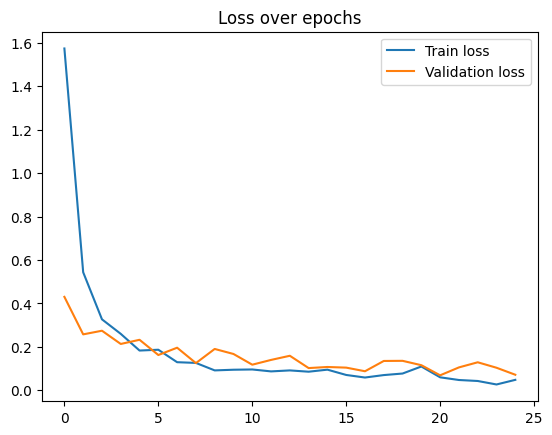

In [104]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

## 🏁 Evaluating the Results

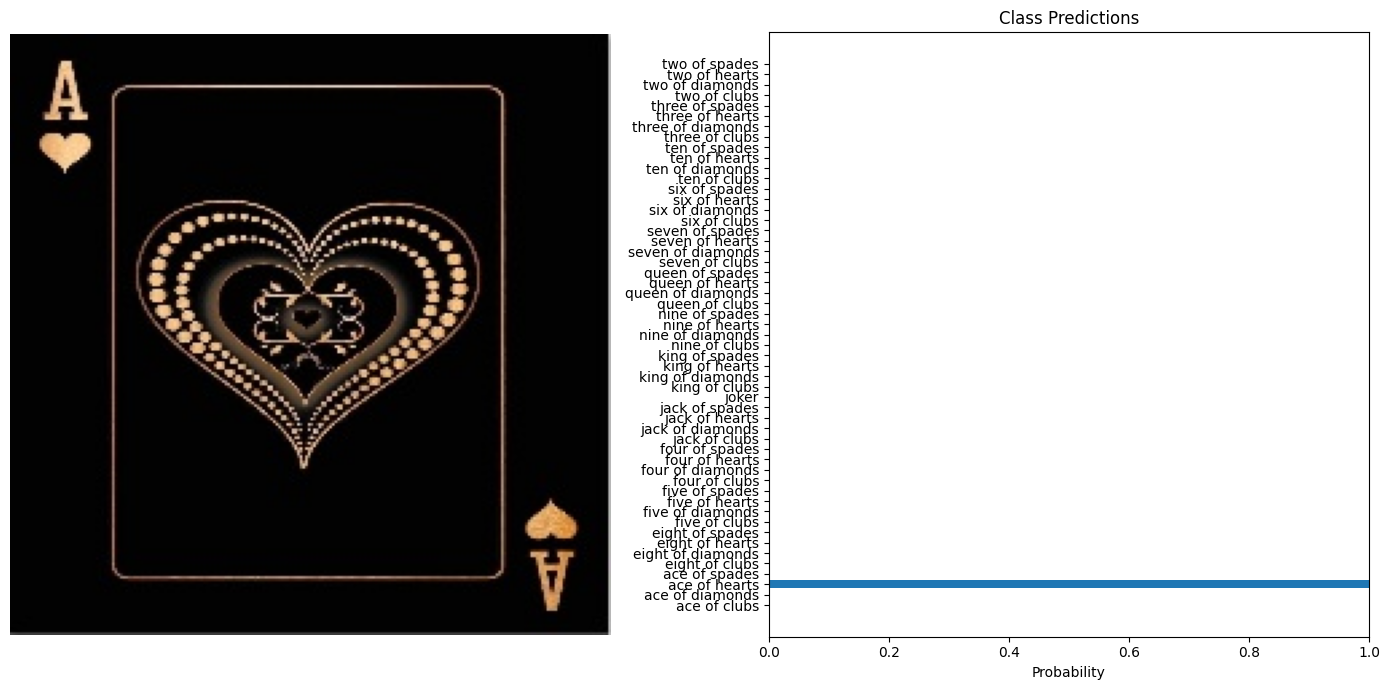

In [105]:
from PIL import Image

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "dataset/cards/test/ace of hearts/4.jpg"

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

### Multiple tests

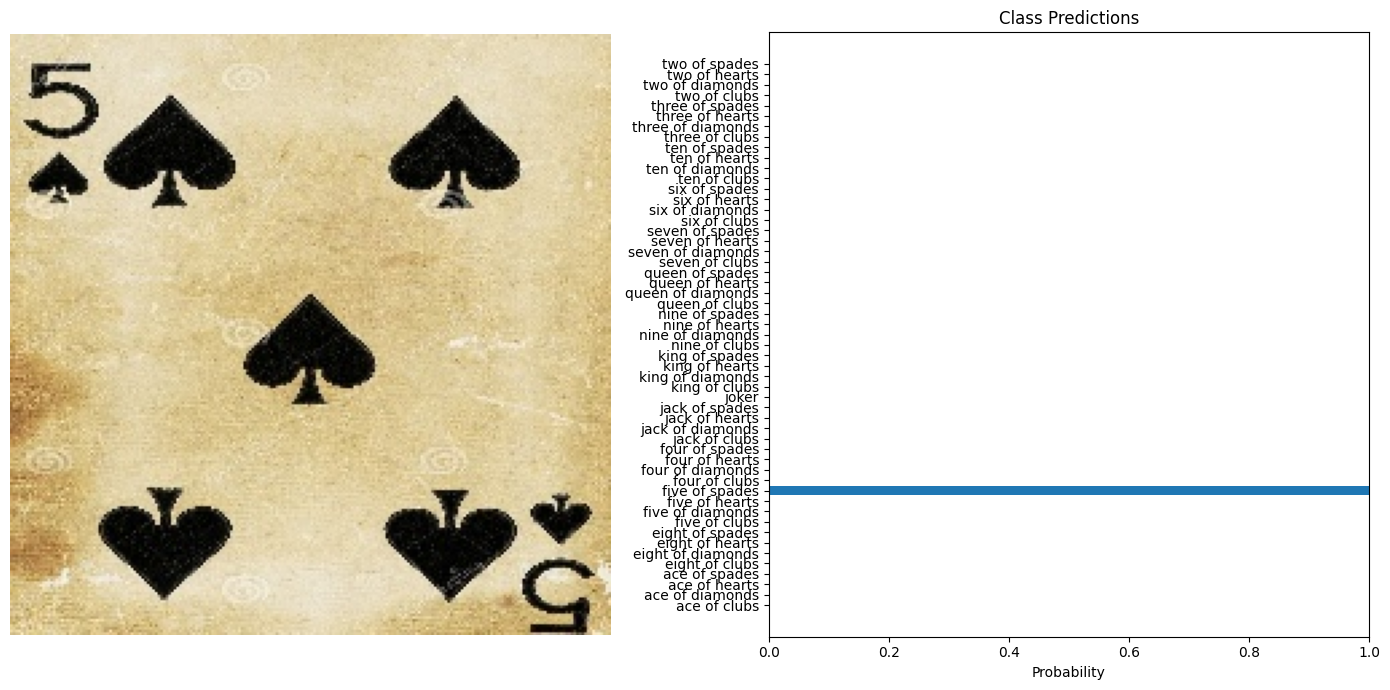

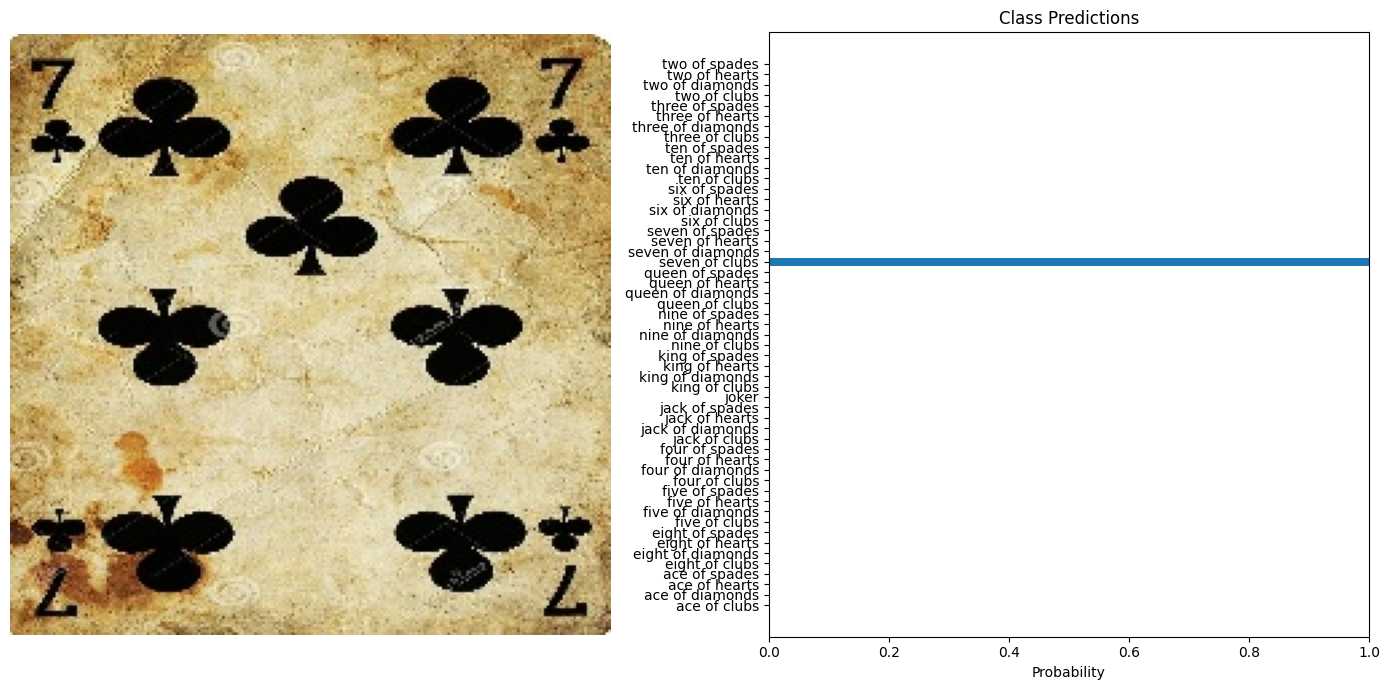

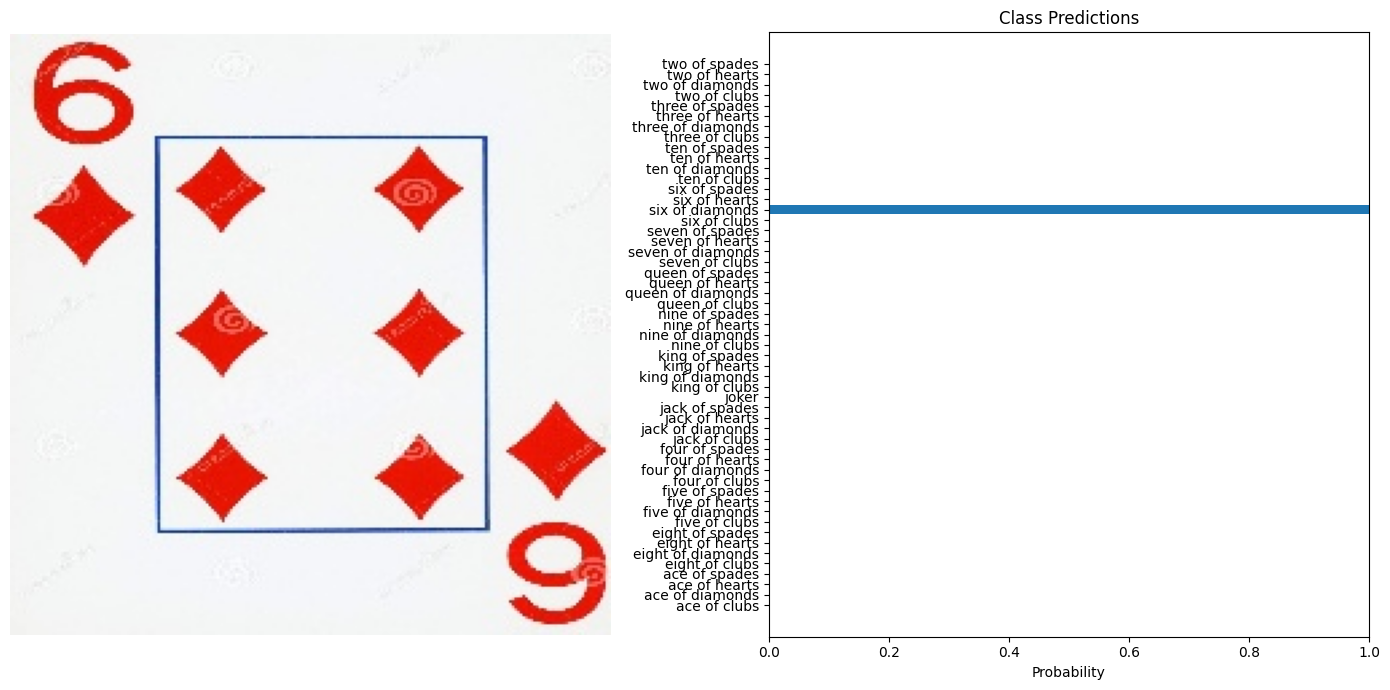

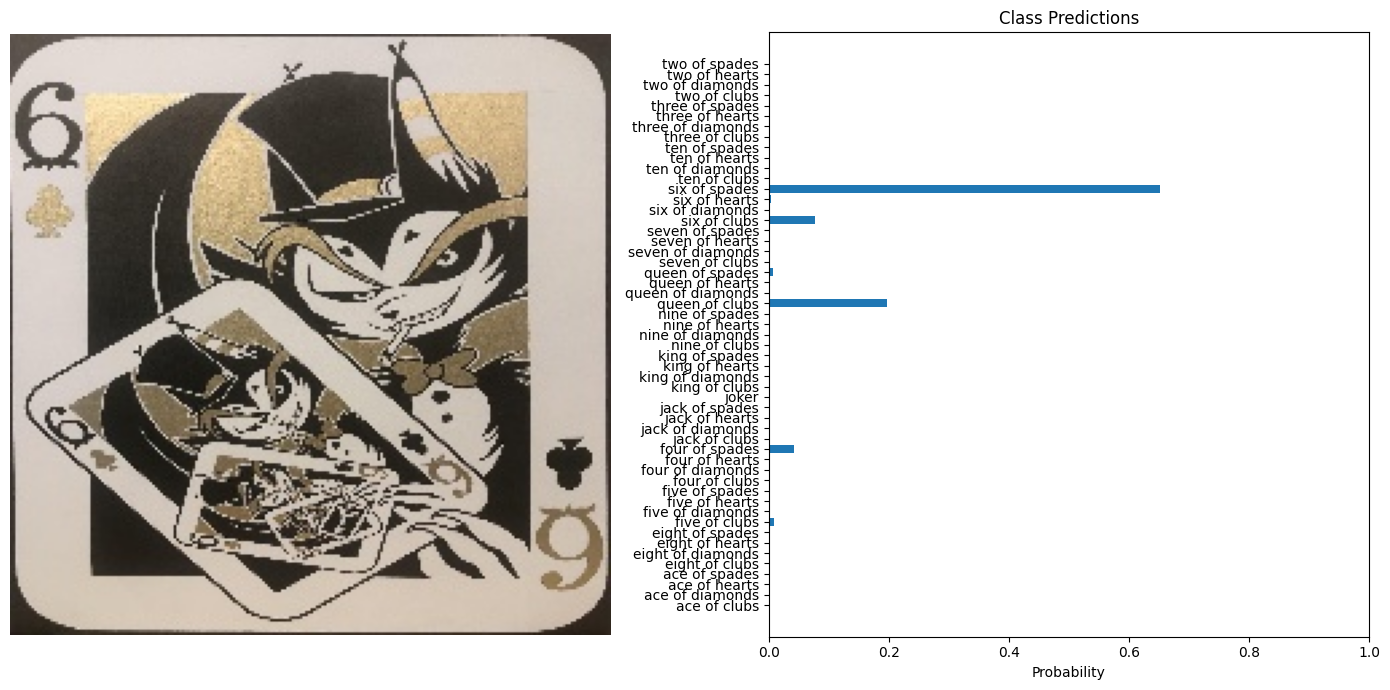

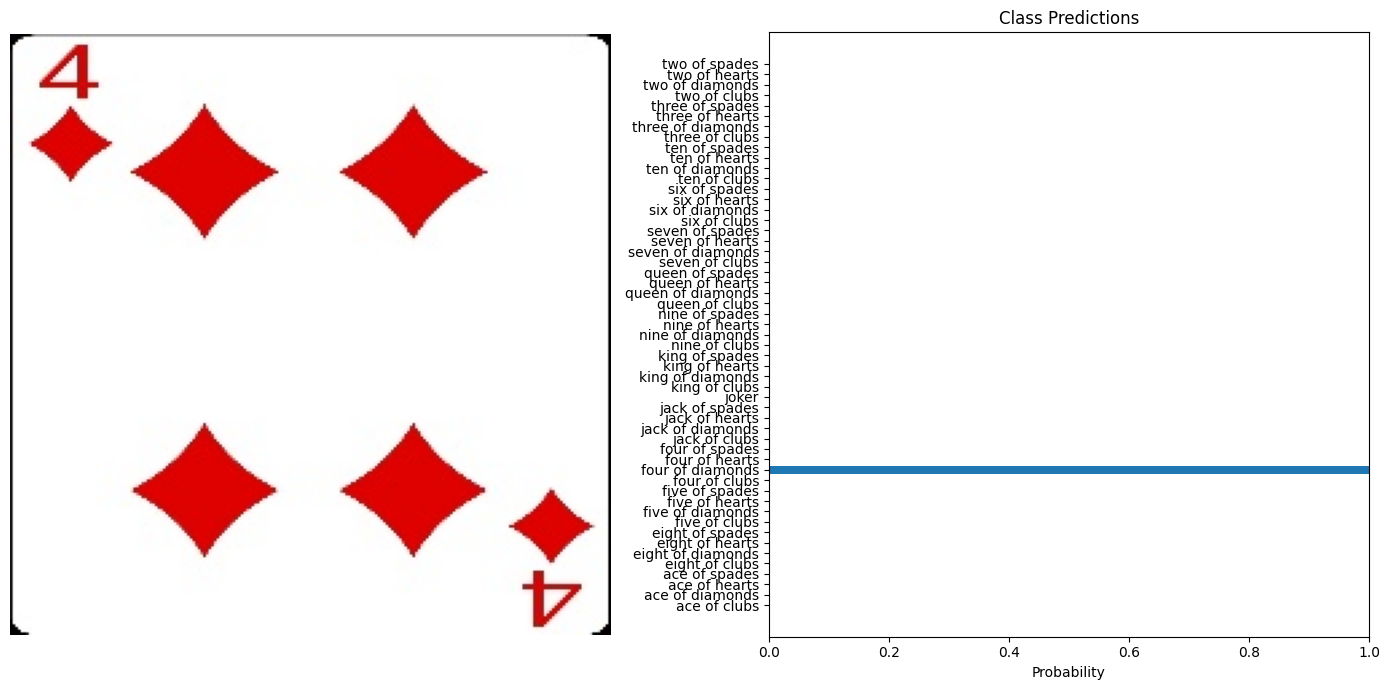

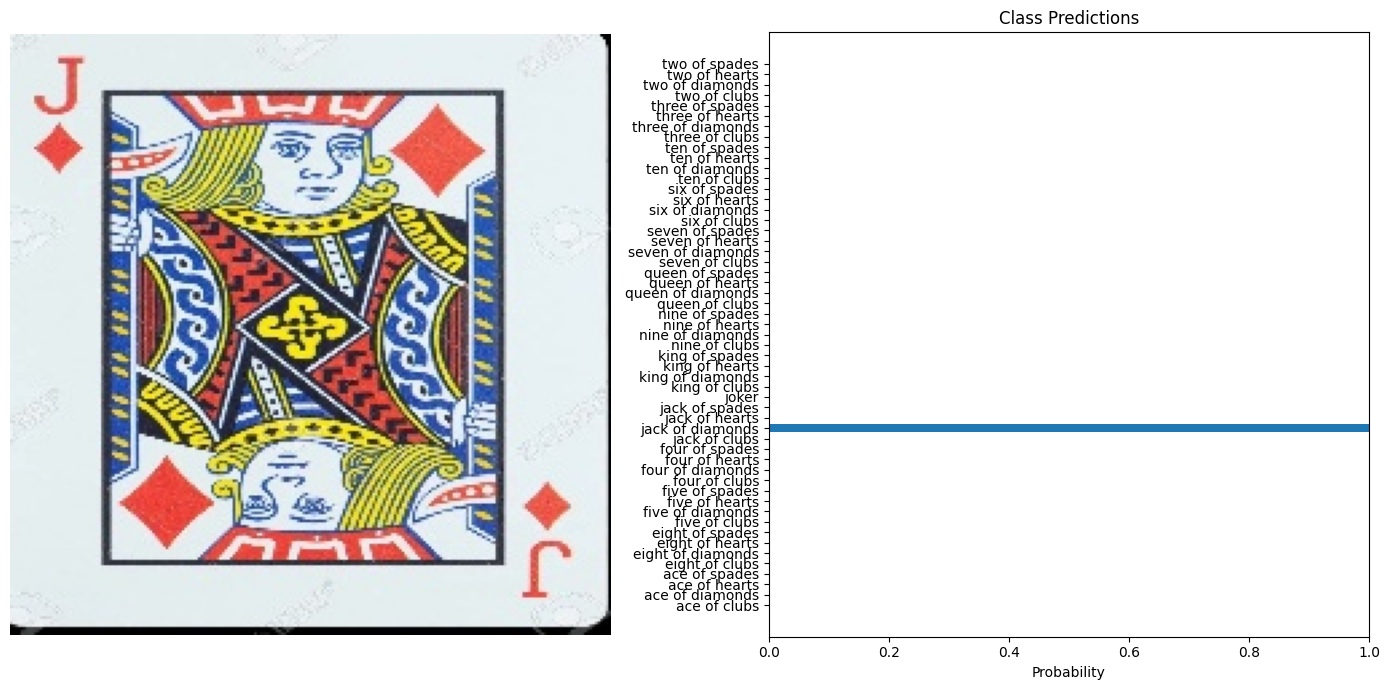

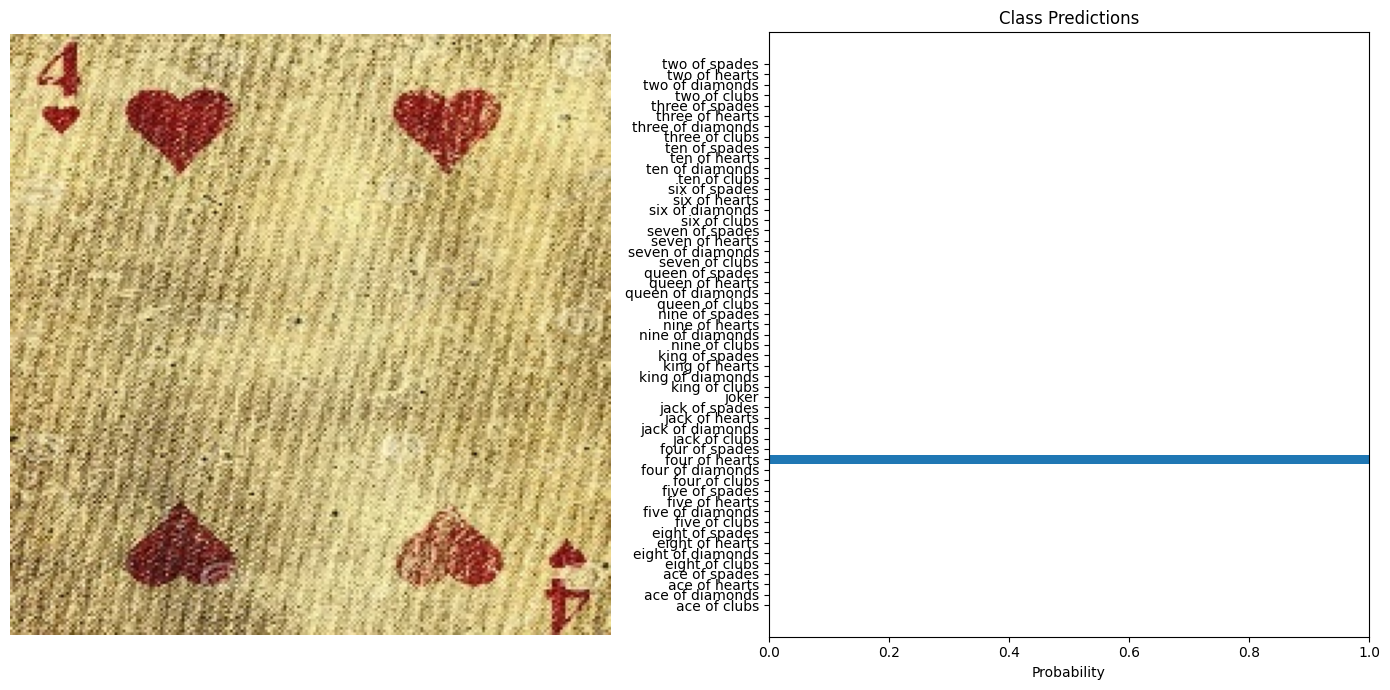

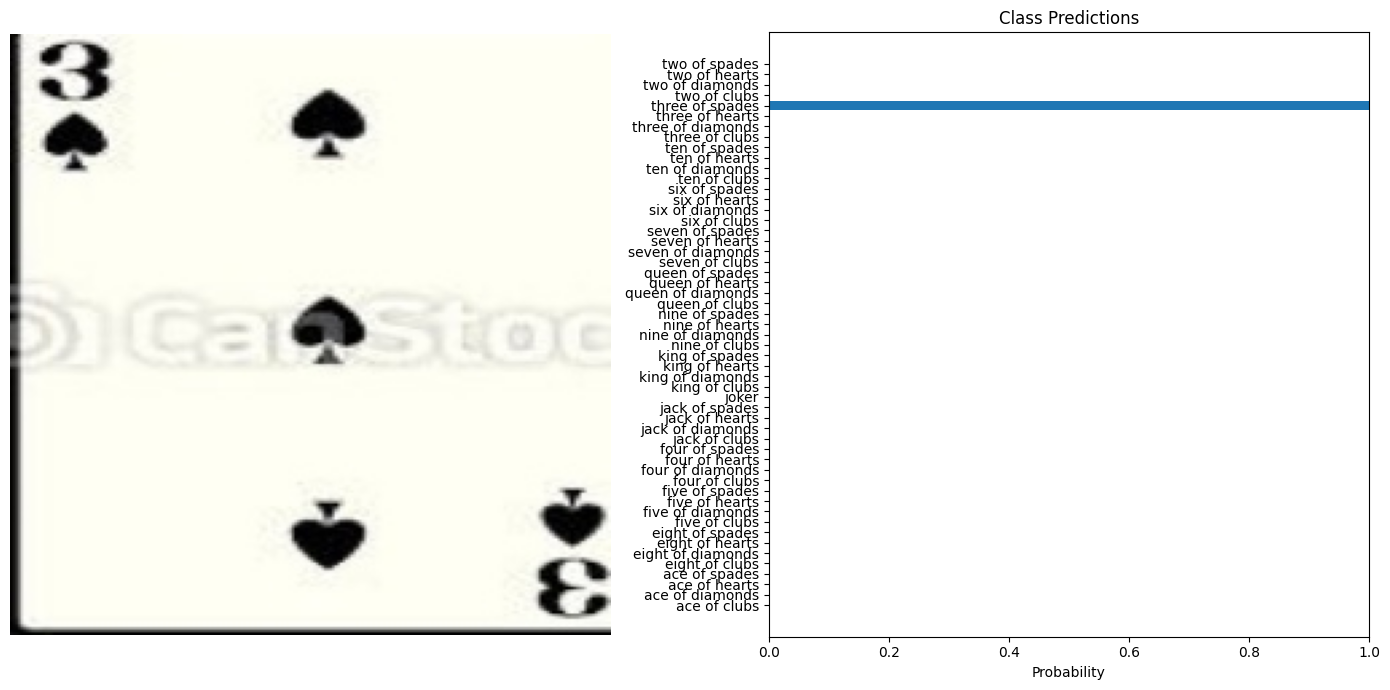

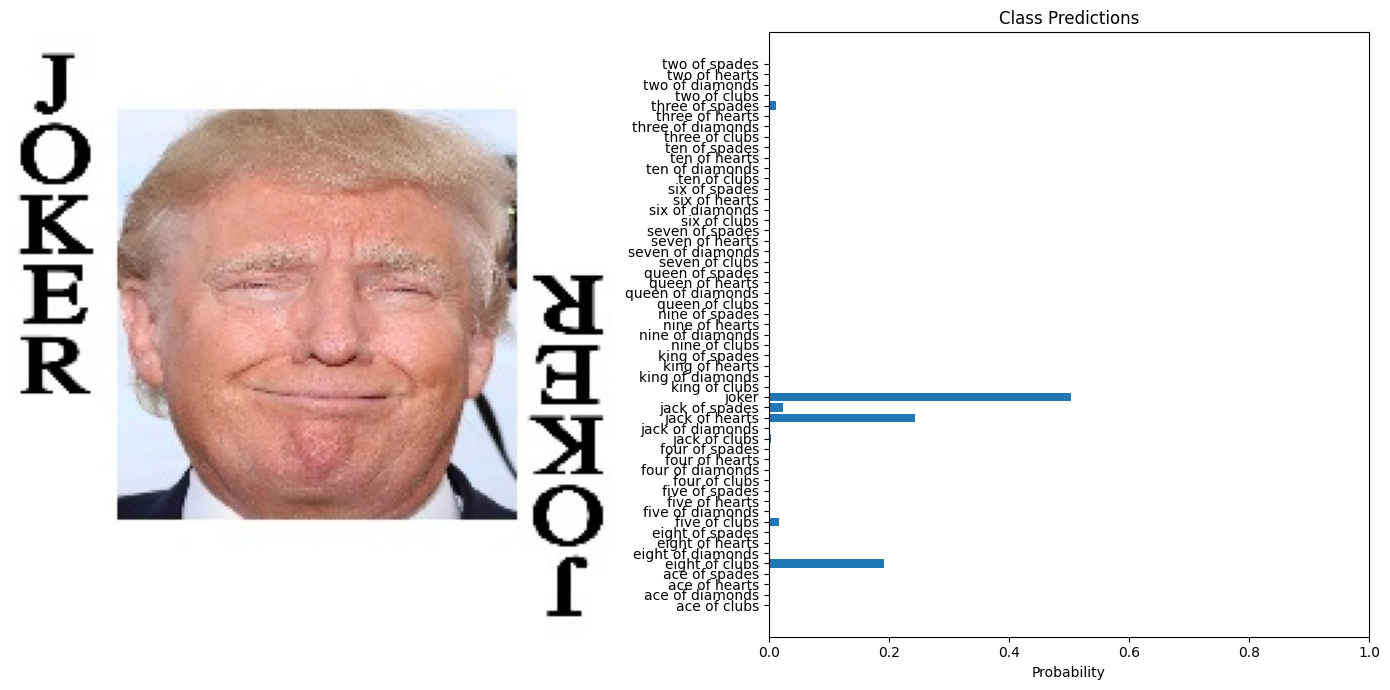

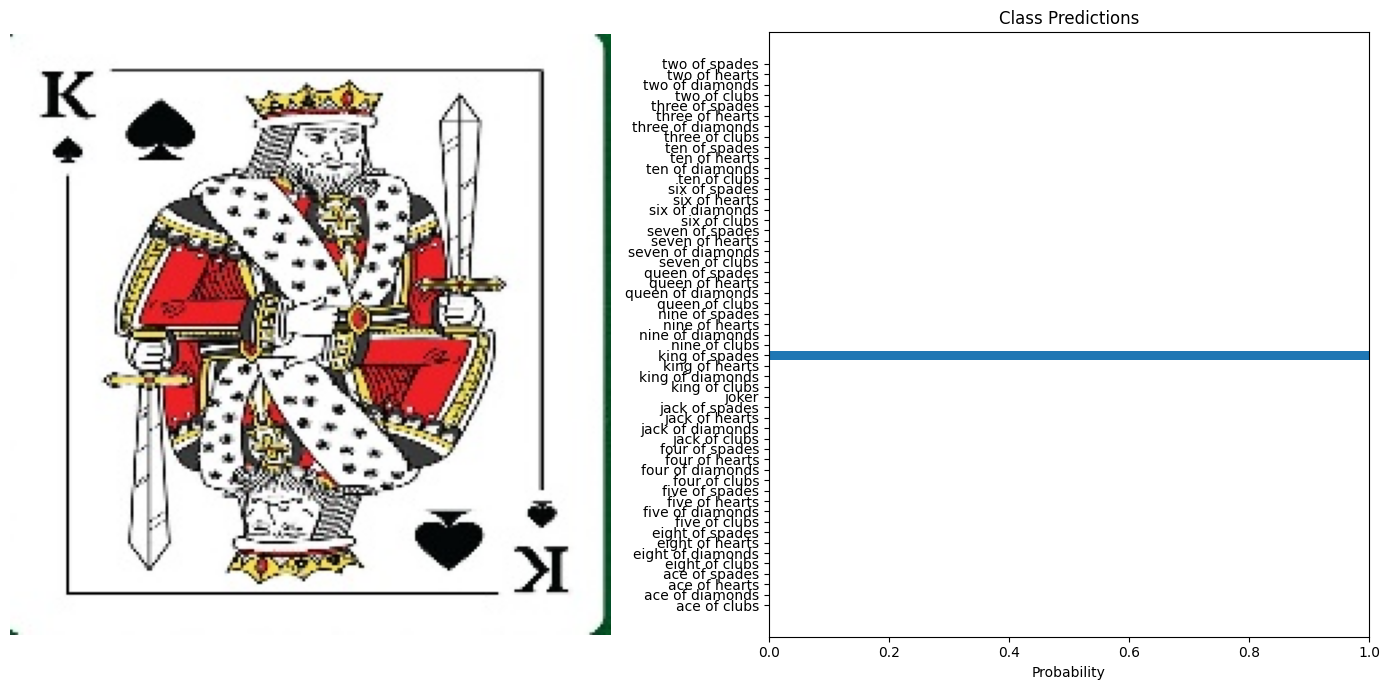

In [106]:
from glob import glob
test_images = glob('dataset/cards/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)